In [1]:
# The BTOP50 is a composite CTA index
# The Bloomberg Agg is a Global Bond index
# The S&P500 is a US Equity Large Cap index 

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
def summary(x,i=0):
    A = x[:].mean()*12
    S = x[:].std()*(12**0.5)
    drawdownVW = pd.DataFrame()
    drawdownVW['cumulative_returns'] = (1 + x).cumprod()
    drawdownVW['rolling_max'] = drawdownVW['cumulative_returns'].cummax()
    drawdownVW['drawdown'] = drawdownVW['cumulative_returns'] / drawdownVW['rolling_max'] - 1
    return (f'Annual Return: {"{:.2f}".format(round(x[:].mean()*1200,2))}%', 
            f'Annual Volatility: {"{:.2f}".format(round(x[:].std()*(12**0.5)*100,2))}%',
            f'Sharpe Ratio: {"{:.2f}".format(round(A/S,2))}',
            f'Max Drawdown: {"{:.1f}".format(round(drawdownVW.drawdown.min()*100,1))}%')

In [4]:
RiskFree = pd.read_csv('/Users/malek/Documents/WRDS Data/US Risk Free Rate Ken French.csv',index_col=0)
RiskFree.index = pd.to_datetime(RiskFree.index,format='%Y%m')
RiskFree = RiskFree.resample('M').last()
RiskFree = RiskFree[786:-11]

In [5]:
SP500 = pd.read_csv('/Users/malek/Documents/WRDS Data/S&P 500 Monthly Returns.csv',index_col=0,parse_dates=True)
data = pd.read_csv('/Users/malek/Documents/WRDS Data/Diversifiers.csv',index_col=0)[['BTOP50','Barclays Aggregate Bond']]
data.index = pd.to_datetime(data.index,dayfirst=True)
data = data.pct_change()
data = data[35:-6].resample('M').last()
data = data.merge(SP500,left_index=True,right_index=True,how='inner')
data.columns = ['BTOP50','Bloomberg Agg','S&P500']
data

,BTOP50,Bloomberg Agg,S&P500
1993-01-31,-0.009051,0.017163,0.000000
1993-02-28,0.068745,0.015791,0.010669
1993-03-31,-0.004814,0.010849,0.017593
1993-04-30,0.031716,0.014336,-0.025588
1993-05-31,0.012490,0.006806,0.026969
...,...,...,...
2022-08-31,0.014924,-0.039461,-0.040802
2022-09-30,0.040763,-0.051380,-0.096159
2022-10-31,0.010372,-0.006877,0.081276
2022-11-30,-0.049728,0.047061,0.055592


In [6]:
# Calculating excess return
# The BTOP50 CTA strategies are self financing, therefore their gross return is their excess return
for i in data.columns[1:]:
    data[i] = data[i] - RiskFree.iloc[:,0]

In [7]:
data.corr()

,BTOP50,Bloomberg Agg,S&P500
BTOP50,1.000000,0.144849,-0.080528
Bloomberg Agg,0.144849,1.000000,0.236473
S&P500,-0.080528,0.236473,1.000000


In [8]:
Tangency_Portfolio = EfficientFrontier(data.mean()*12,data.cov()*12,weight_bounds=(0,1))
Tangency_Portfolio.add_constraint(lambda w: w[0]+w[1]+w[2]
== 1)
weights = Tangency_Portfolio.max_sharpe(risk_free_rate=0.0)
weights = Tangency_Portfolio.clean_weights()
Tangency_Portfolio.portfolio_performance(verbose=True)
weights

Expected annual return: 5.0%
Annual volatility: 6.0%
Sharpe Ratio: 0.84


OrderedDict([('BTOP50', 0.61204),
             ('Bloomberg Agg', 0.1815),
             ('S&P500', 0.20647)])

In [9]:
MVOweights = []
for i in data.columns:
    MVOweights.append(weights[i])

MVO = ((data*MVOweights).sum(axis=1))
data['Mean Variance'] = MVO
data['60/40'] = (data['S&P500']*0.6) + (data['Bloomberg Agg']*0.4)

In [10]:
# Normalised to 20% Volatility
for i in data.columns:
    std = data[i].std()*(12**0.5)
    scailer = 0.20/std
    data[i] = data[i]*scailer

data = data[['Mean Variance','BTOP50','60/40','S&P500','Bloomberg Agg']]

In [11]:
# Performance Summary Statistics
for i in data.columns:
    print(i,summary(data[i]))

Mean Variance ('Annual Return: 16.80%', 'Annual Volatility: 20.00%', 'Sharpe Ratio: 0.84', 'Max Drawdown: -29.1%')
BTOP50 ('Annual Return: 13.69%', 'Annual Volatility: 20.00%', 'Sharpe Ratio: 0.68', 'Max Drawdown: -37.2%')
60/40 ('Annual Return: 9.14%', 'Annual Volatility: 20.00%', 'Sharpe Ratio: 0.46', 'Max Drawdown: -64.1%')
S&P500 ('Annual Return: 8.22%', 'Annual Volatility: 20.00%', 'Sharpe Ratio: 0.41', 'Max Drawdown: -73.9%')
Bloomberg Agg ('Annual Return: 6.89%', 'Annual Volatility: 20.00%', 'Sharpe Ratio: 0.34', 'Max Drawdown: -66.6%')


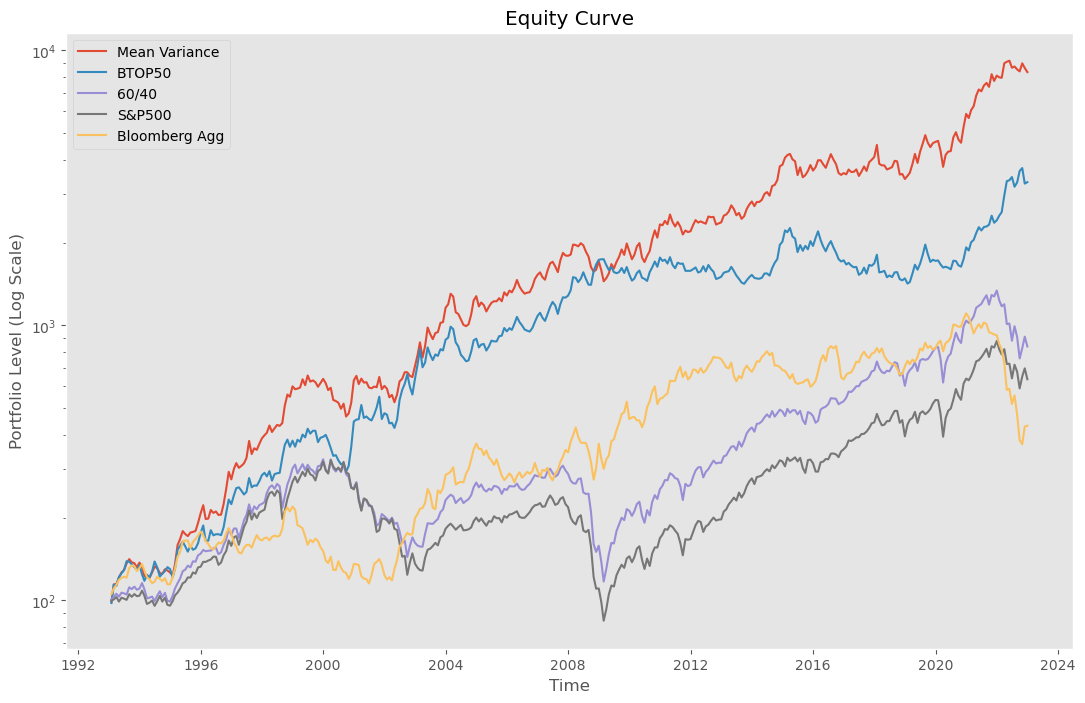

In [12]:
fig = plt.figure(figsize=(13,8))
plt.style.use('ggplot')
plt.plot(data.index,100*(data+1).cumprod(),label=data.columns)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Portfolio Level (Log Scale)')
plt.title('Equity Curve')
plt.yscale('log')
plt.grid(False)
plt.show()